Okay, today we are moving up in the world and I'm going to use the magic of neural networks to forecast volatility.

# The Data

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from scipy import stats

# Set default figure size
plt.rcParams["figure.figsize"] = (15, 10)
pd.plotting.register_matplotlib_converters()

In [2]:
# Here"s my minute data for the S&P 500
spx_minute = pd.read_csv("SPX_1min.csv", header=0,names=["datetime", "open", "high", "low", "close"],
                                  index_col="datetime", parse_dates=True)

In [3]:
# Here"s the function for calculating the 1-min RV, as discussed in my last post
def rv_calc(data):
    results = {}
    
    for idx, data in data.groupby(data.index.date):
        returns = np.log(data["close"]) - np.log(data["close"].shift(1))
        results[idx] = np.sum(returns**2)
        
    return pd.Series(results)

In [4]:
spx_variance = rv_calc(spx_minute)

In [5]:
conn = sqlite3.Connection("data.db")
spx_data = pd.read_sql("SELECT * FROM prices WHERE ticker='^GSPC'", conn, index_col="date", parse_dates="date")
spx_returns = np.log(spx_data["close"]) - np.log(spx_data["close"].shift(1))
spx_returns = spx_returns.dropna()

vix_data = pd.read_sql("SELECT * FROM prices WHERE ticker='^VIX'", conn, index_col="date", parse_dates="date")
# This puts it into units of daily standard deviation
vix = vix_data["close"] / np.sqrt(252) / 100

In [8]:
def create_lags(series, lags, name="x"):
    """
    Creates a dataframe with lagged values of the given series.
    Generates columns named x_t-n which means the value of each row is the value of the original series lagged n times
    """
    result = pd.DataFrame(index=series.index)
    result[f"{name}_t"] = series
    
    for n in range(lags):
        result[f"{name}_t-{n+1}"] = series.shift((n+1))
        
    return result

The predictive variables are the VIX, returns of the index, and our calculated realized variance. I include the 21 past values of these variables.

In [813]:
vix_lags = create_lags(np.log(vix), 21, name="vix")
return_lags = create_lags(spx_returns, 21, name="returns")
rv_lags = create_lags(np.log(spx_variance), 21, name="rv")

x = pd.concat([vix_lags, return_lags, rv_lags], axis=1).dropna()
# We want to predict log of variance
y = np.log(spx_variance.rolling(5).sum().shift(-5)).dropna()

common_index = x.index.intersection(y.index)
x = x.loc[common_index]
y = y.loc[common_index]

# The Model

I'm using a mixture density network to model future volatility. This is because I want an estimate of the future *distribution* of volatility, not just a point estimate. A mixture density network outputs the parameters for making a mixture of normal distributions. This is useful because you can approximate any arbitrary distribution with a large enough mixture of only normal distributions.

In [797]:
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, Independent, MixtureSameFamily
from torch.optim.swa_utils import AveragedModel, SWALR

torch.set_default_dtype(torch.float64)

In [798]:
class MDN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, n_components):
        super().__init__()
        self.n_components = n_components
        # Last layer output dimension rationale:
        # Need two parameters for each distributionm thus 2 * n_components.
        # Need each of those for each output dimension, thus that multiplication
        self.norm_network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, 2 * n_components * out_dim)
        )
        self.cat_network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, n_components * out_dim)
        )
        
    def forward(self, x):
        norm_params = self.norm_network(x)
        # Split so we get parameters for mean and standard deviation
        mean, std = torch.split(norm_params, norm_params.shape[1] // 2, dim=1)
        # We need rightmost dimension to be n_components for mixture
        mean = mean.view(mean.shape[0], -1, self.n_components)
        std = std.view(std.shape[0], -1, self.n_components)
        normal = Normal(mean, torch.exp(std))
        
        cat_params = self.cat_network(x)
        # Again, rightmost dimension must be n_components
        cat = Categorical(logits=cat_params.view(cat_params.shape[0], -1, self.n_components))
        
        return MixtureSameFamily(cat, normal)

In [799]:
test_index = int(len(x) * .75)
train_x = torch.Tensor(x.iloc[:test_index].values)
train_y = torch.Tensor(y.iloc[:test_index].values)
test_x = torch.Tensor(x.iloc[test_index:].values)
test_y = torch.Tensor(y.iloc[test_index:].values)

in_dim = len(x.columns)
out_dim = 1
n_components = 5
hidden_dim = 250

Below here is the training loop. I'm using a cosine annealing learning rate schedule to better explore the parameter space, as well as using model averaging over the last 500 iterations so the model generalizes better.

In [818]:
model = MDN(in_dim, out_dim, hidden_dim, n_components)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, 2)

swa_model = AveragedModel(model)
swa_start = 400
swa_scheduler = SWALR(optimizer, swa_lr=0.001, anneal_epochs=10, anneal_strategy="cos")

train_losses = []
validation_losses = []
model.train()
swa_model.train()
for epoch in range(500):
    optimizer.zero_grad()
    output = model(train_x)

    train_loss = -output.log_prob(train_y.view(-1, 1)).sum()
    train_losses.append(train_loss.detach())
    
    test_loss = -model(test_x).log_prob(test_y.view(-1, 1)).sum()
    validation_losses.append(test_loss.detach())
    
    train_loss.backward()
    optimizer.step()
    
    if epoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()

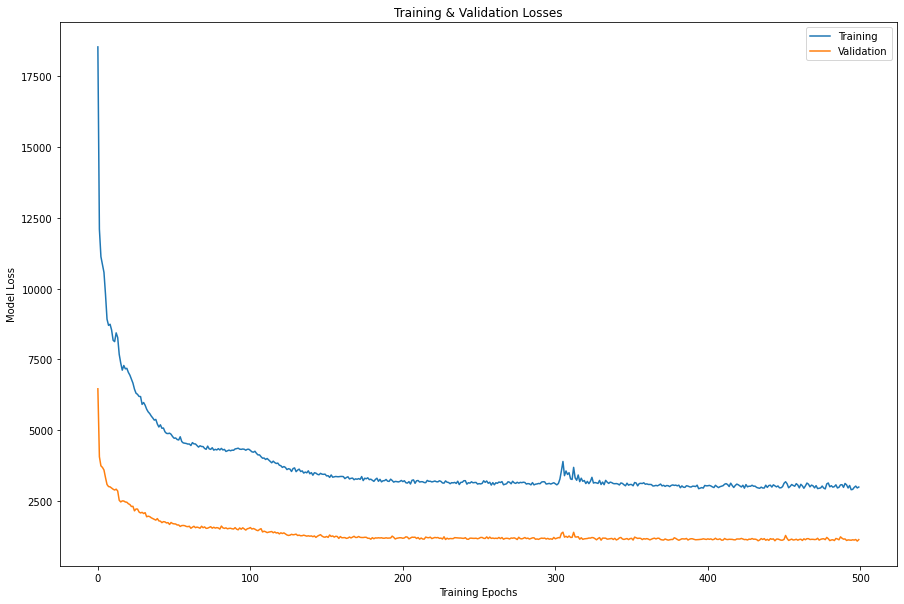

In [833]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.xlabel("Training Epochs")
plt.ylabel("Model Loss")
plt.title("Training & Validation Losses")
plt.legend(["Training", "Validation"])

In [820]:
swa_model.eval()
output_mean = np.sqrt(np.exp(swa_model(test_x).mean.detach().numpy().squeeze()))
y_trans = np.sqrt(np.exp(test_y.numpy().squeeze()))

output_sample = np.sqrt(np.exp(swa_model(test_x).sample([5000]).numpy().squeeze()))

Our out-of-sample R-squared is excellent, much higher than my previous simple linear model.

In [835]:
regress = stats.linregress(output_mean, y_trans)
print(f"R-squared: {regress.rvalue**2}")

R-squared: 0.7128714654332561


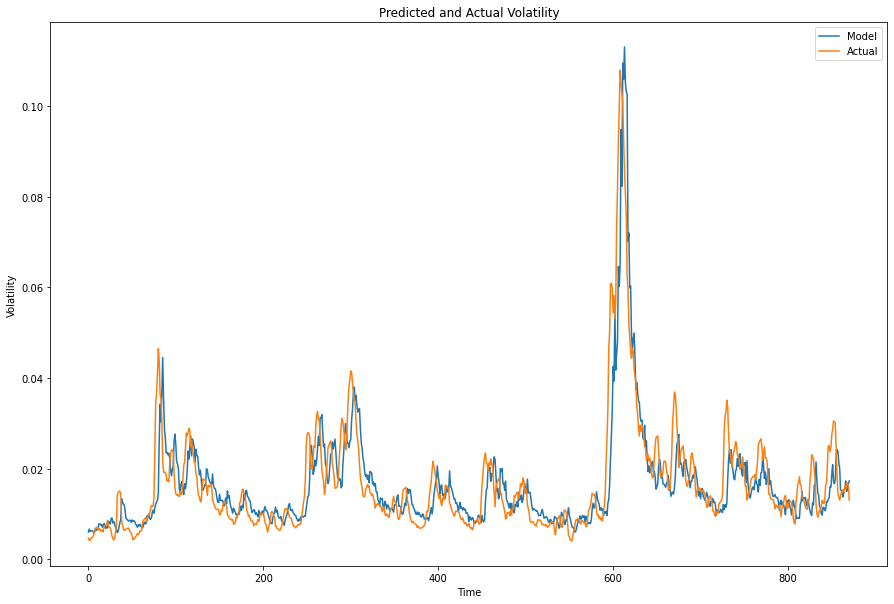

In [837]:
plt.plot(output_mean)
plt.plot(y_trans)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Predicted and Actual Volatility")
plt.legend(["Model", "Actual"])

Our distributional assumption also does well. We expect 5% of cases to be outside what the model distribution forecasts, and we find that to be the case.

In [838]:
percent = np.percentile(output_sample, 95, axis=0)
print(f"Number of exceedences: {(y_trans > percent).sum() / len(y_trans)}")

Number of exceedences: 0.04477611940298507


Further testing the distribution accuracy, let's see if doing a probability integral transform yields a uniform.

In [827]:
class ECDF:
    def __init__(self, data):
        self.sorted = data
        self.sorted.sort()
        self.y = np.arange(1, len(self.sorted) + 1) / len(self.sorted)
        
    def __call__(self, x):
        ind = np.searchsorted(self.sorted, x) - 1
        return self.y[ind]

In [828]:
values = []

for x in range(len(y_trans)):
    ecdf = ECDF(output_sample[x])
    values.append(ecdf(y_trans[x]))

(array([ 75., 121.,  76.,  89.,  81.,  93.,  79.,  79., 103.,  75.]),
 array([0.00459242, 0.10378875, 0.20298507, 0.3021814 , 0.40137773,
        0.50057405, 0.59977038, 0.6989667 , 0.79816303, 0.89735936,
        0.99655568]),
 <BarContainer object of 10 artists>)

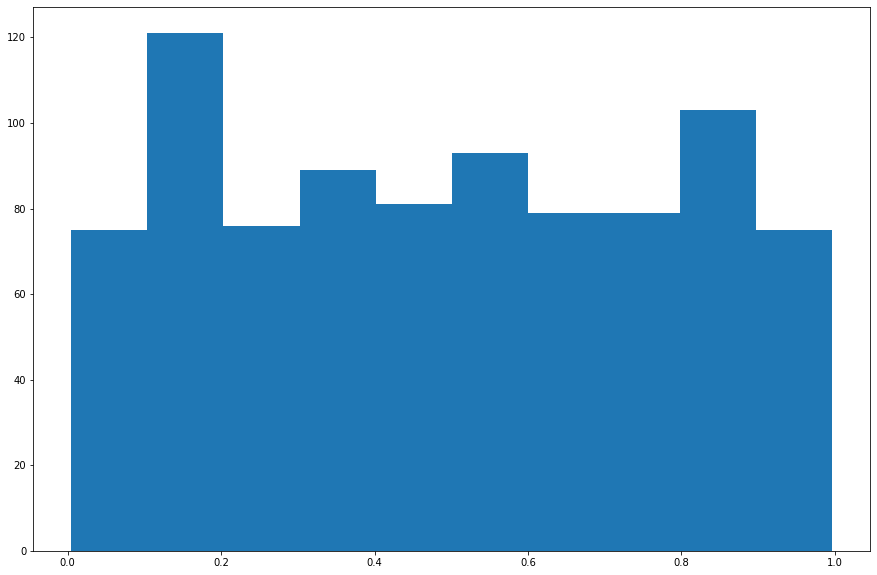

In [829]:
plt.hist(values, bins=10)

In [830]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.028702640642939155, pvalue=0.46125545362008036)

We can't reject the null hypothesis that the transformed values come from a uniform distribution! That means our distributions accurately models the data's real distribution.

# Conclusion

This model seems quite excellent. I'm going to use this model for my future posts about how to make an effective trading strategy. Next time I'm going to discuss Kelly Bet Sizing and its application to continuous distributions.